# About timeline_viz.ipynb

This notebook uses the functions defined and demontrasted in *utils_timeline_viz.ipynb* to clean log data and visualize it.
This is a work in progress :)

In [1]:
exec(open('load_utils.py').read())
from utils_timeline_viz import *

importing notebook from utils_timeline_viz.ipynb
importing function: find_student_log_file
importing function: remove_model_events
importing function: calculate_duration
importing function: prep_parsing_data
importing function: add_family
importing function: get_blocks_withTime
importing function: plot_barGraph_new
importing function: action_usage
importing function: plot


In [2]:
studentid = '90447168'
sim = 'beers'
# parsed_file = find_student_log_file(FOLDER,sim,studentid)
parsed_file = 'dream_table_beers-law-lab_90447168_2017-01-17_11.22.45.txt'
df = prep_parsing_data(parsed_file)

C:\Users\sperez8\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [3]:
studentid = '83459165'
sim = 'beers'
# parsed_file = find_student_log_file(FOLDER,sim,studentid)
parsed_file = 'dream_table_beers-law-lab_83459165_2017-01-13_14.26.08.txt'
df2 = prep_parsing_data(parsed_file)

In [4]:
studentid = '13122150'
sim = 'beers'
# parsed_file = find_student_log_file(FOLDER,sim,studentid)
parsed_file = 'dream_table_beers-law-lab_13122150_2017-01-27_13.27.17.txt'
df3 = prep_parsing_data(parsed_file)

In [5]:
studentid = '19566168'
sim = 'beers'
# parsed_file = find_student_log_file(FOLDER,sim,studentid)
parsed_file = 'dream_table_beers-law-lab_19566168_2017-01-27_13.27.13.txt'
df4 = prep_parsing_data(parsed_file)

In [6]:
def action_usage(df,column,regex):
    '''Given a regex, we detect its use using a particular column
    and then extract a list of time coordinates for when
    they were used. These coordinates are in the format (start_time, duration)
    
    Args:
        df (Pandas dataframe): The dataframe to search in.
        column (str): The column where the action regex might be logged (usualy the Family column)
        regex (str): The regex or often the name of the action family to search for in the column.    

    Returns:
        A list of tuples with start times of the regex and it's duration [(start1,duration1),(start2,duration2),...]
    '''
    if df[column].isnull().values.all():
        return [(0,0)]
    else:
        timecoords = zip(df[df[column].str.contains(regex,na=False)]['Time'],df[df[column].str.contains(regex,na=False)]['Duration'])
        return clean_coords(timecoords)

In [7]:
def axis_absorbance_usage(df):
    x_axis_usage = action_usage(df,'X axis','absorbance')
    y_axis_usage = action_usage(df,'Y axis','absorbance')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_trialNumber_usage(df):
    x_axis_usage = action_usage(df,'X axis','trialNumber')
    y_axis_usage = action_usage(df,'Y axis','trialNumber')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_width_usage(df):
    x_axis_usage = action_usage(df,'X axis','cuvetteWidth')
    y_axis_usage = action_usage(df,'Y axis','cuvetteWidth')
    return merge_usage(x_axis_usage,y_axis_usage)

def axis_concentration_usage(df):
    x_axis_usage = action_usage(df,'X axis','concentration')
    y_axis_usage = action_usage(df,'Y axis','concentration')
    return merge_usage(x_axis_usage,y_axis_usage)

def get_value_and_coords(df,variable):
    usage = action_usage(df,'Family',family_name_to_code[variable])
    values = df[df['Family'].str.contains(family_name_to_code[variable],na=False)][variable]
    coords = df[df['Family'].str.contains(family_name_to_code[variable],na=False)]['Time']
    return values, coords, usage

In [8]:
family_name_to_code = {'Interface':'I',
                        'Pause':'P',
                        'Graph (add/del/edit)':'G',
                        'Data Table (del/move)':'Dt',
                        'Notes':'N',
                        'Record':'M',
                        'Detector':'Vd',
                        'Wavelength':'Vw',
                        'Width':'Vc',
                        'Concentration':'Vs',
                        'Laser toggle':'Vl',
                        }

function_to_use = {'Axis - absorbance':axis_absorbance_usage,
                   'Axis - trialNumber':axis_trialNumber_usage,
                   'Axis - width':axis_width_usage,
                   'Axis - concentration':axis_concentration_usage,
                  'Wavelength':get_value_and_coords,
                  'Width':get_value_and_coords,
                  'Concentration':get_value_and_coords}

to_plot = ['Interface','Notes','Pause','Axis - absorbance','Axis - trialNumber','Axis - width','Axis - concentration','Graph (add/del/edit)','Data Table (del/move)','Record','Detector','Wavelength','Width','Concentration','Laser toggle']

In [9]:
def get_value_and_coords(df,variable):
    usage = action_usage(df,'Family',family_name_to_code[variable])
    values = df[df['Family'].str.contains(family_name_to_code[variable],na=False)][variable]
    coords = df[df['Family'].str.contains(family_name_to_code[variable],na=False)]['Time']
    return values, coords, usage

In [10]:
def plot(df,to_plot,family_name_to_code,function_to_use):
    ax = plt.subplot()
    spacing = 10
    margin = 1.0
    max_time = 0
#     colors = sns.color_palette("hls", len(to_plot))
    colors = sns.husl_palette(len(to_plot), l=.4, s=1)
#     sns.palplot(sns.husl_palette(len(to_plot), l=.5, s=.7))
    
    for i,action in enumerate(to_plot):
        alpha = 0.9
        color = colors[i]
        if action in ['Wavelength','Width','Concentration']:
            #get time coords for changes in that variable, and the values of those changes
            values,coords,action_use = function_to_use[action](df,action)
            min_v,max_v = min(values),max(values)
            values = [(v-min_v)/(max_v-min_v)*(spacing-margin) +i*spacing for v in values] #normalize so it fits in x_axis
#             ax.plot(coords,values,'o',color=colors[i],markersize=3,alpha=1)
            ax.plot(coords,values,'-',color=colors[i],linewidth=2,alpha=1)
            alpha = 0.3
        elif action in family_name_to_code.keys():
            action_use = action_usage(df,'Family',family_name_to_code[action])
            action_use = clean_coords(action_use)
        else:
            action_use = function_to_use[action](df)            
        if action_use:
            if action in ['Pause','Notes','Record']:
                a = 0.1
                if action == 'Record':
                    a = 0.5
                ax.broken_barh(action_use,(i*spacing,(spacing)*(len(to_plot)-i)),facecolors=color,linewidth=0,edgecolor='k',alpha=a)
            if 'Axis' in action:
                color = 'grey'
                alpha = 0.5
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(i*spacing,(spacing-margin)),facecolors=color,alpha=alpha,linewidth=0,edgecolor='k')

    #Shape plot
    ax.set_ylim(-2, len(to_plot)*spacing+2)
    ax.set_xlim(0, max_time+2)
    
    #Add labels
    ax.set_xlabel('Time (min)',fontsize=25)
    ax.set_xticks(range(0,int(max_time),60))
    ax.set_xticklabels([str(x/60)+''if x in range(0,int(max_time),60*5) else "" for x in range(0,int(max_time),60)],fontsize=13)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(spacing/2,len(to_plot)*spacing,spacing))
    ax.set_yticklabels([a.capitalize() for a in to_plot],fontsize=25)
    ax.grid(True)

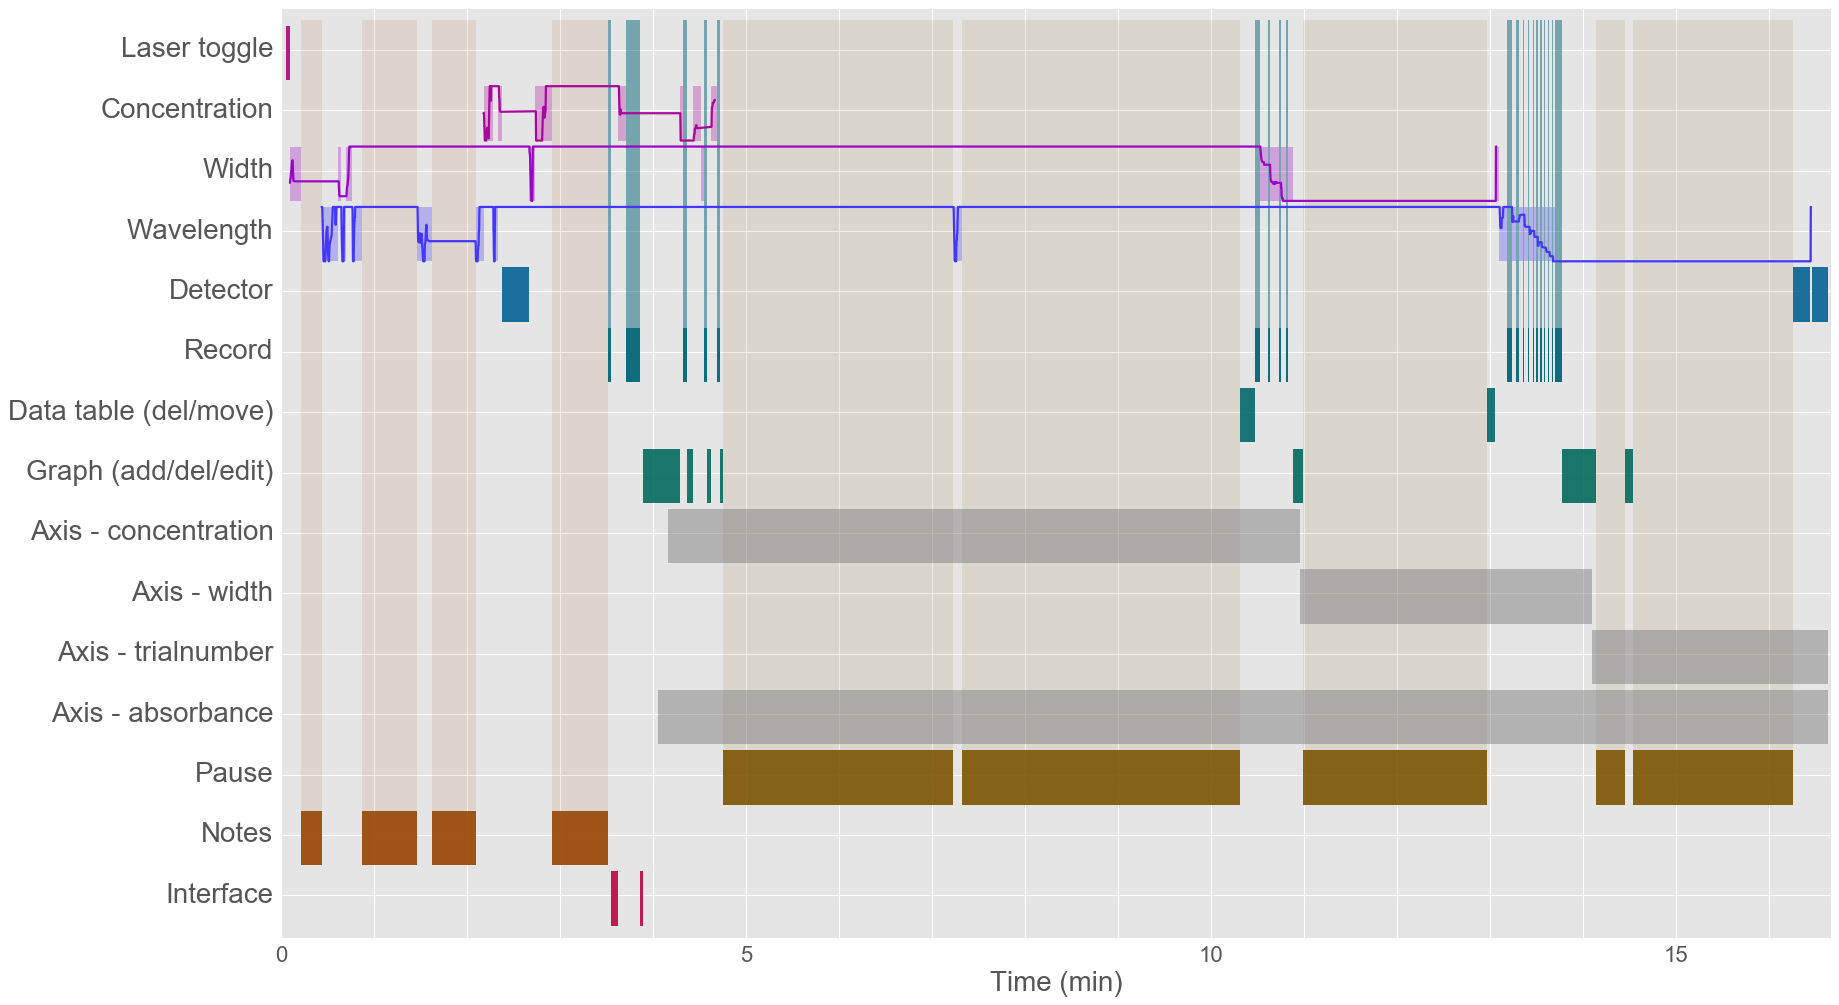

In [11]:
#'90447168'
plot(df,to_plot,family_name_to_code,function_to_use)

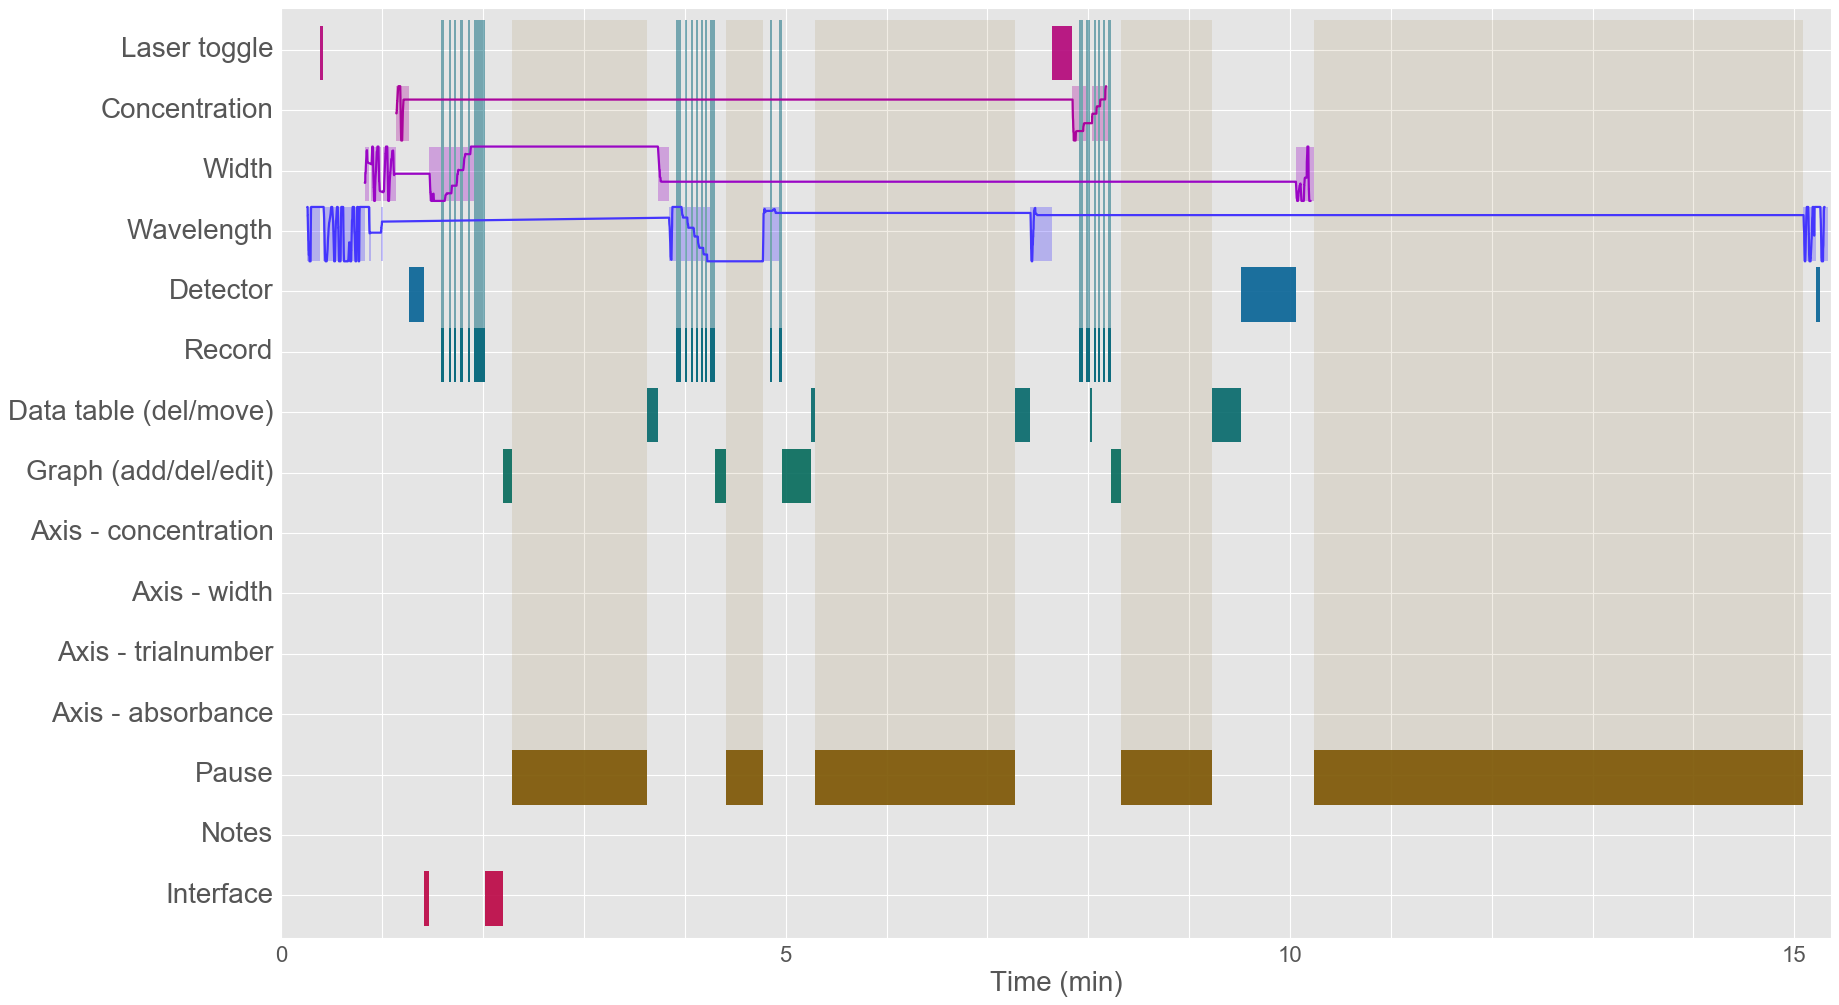

In [12]:
plot(df2,to_plot,family_name_to_code,function_to_use)

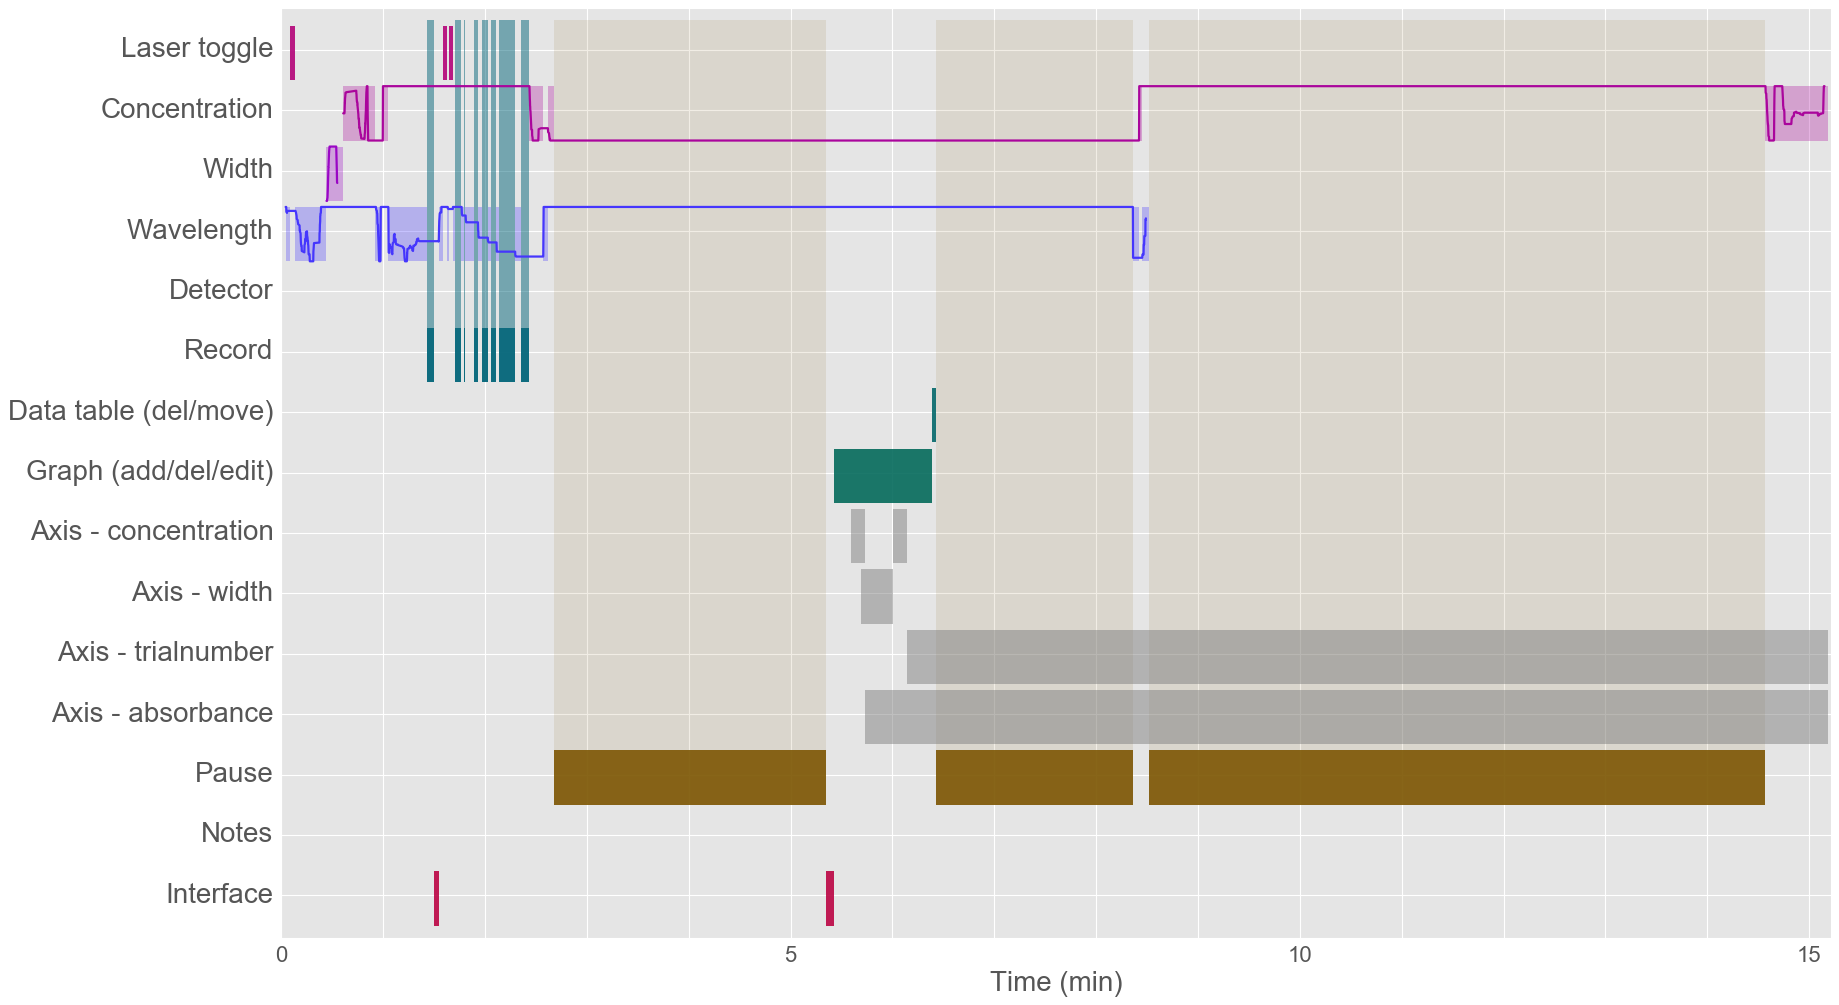

In [13]:
plot(df3,to_plot,family_name_to_code,function_to_use)

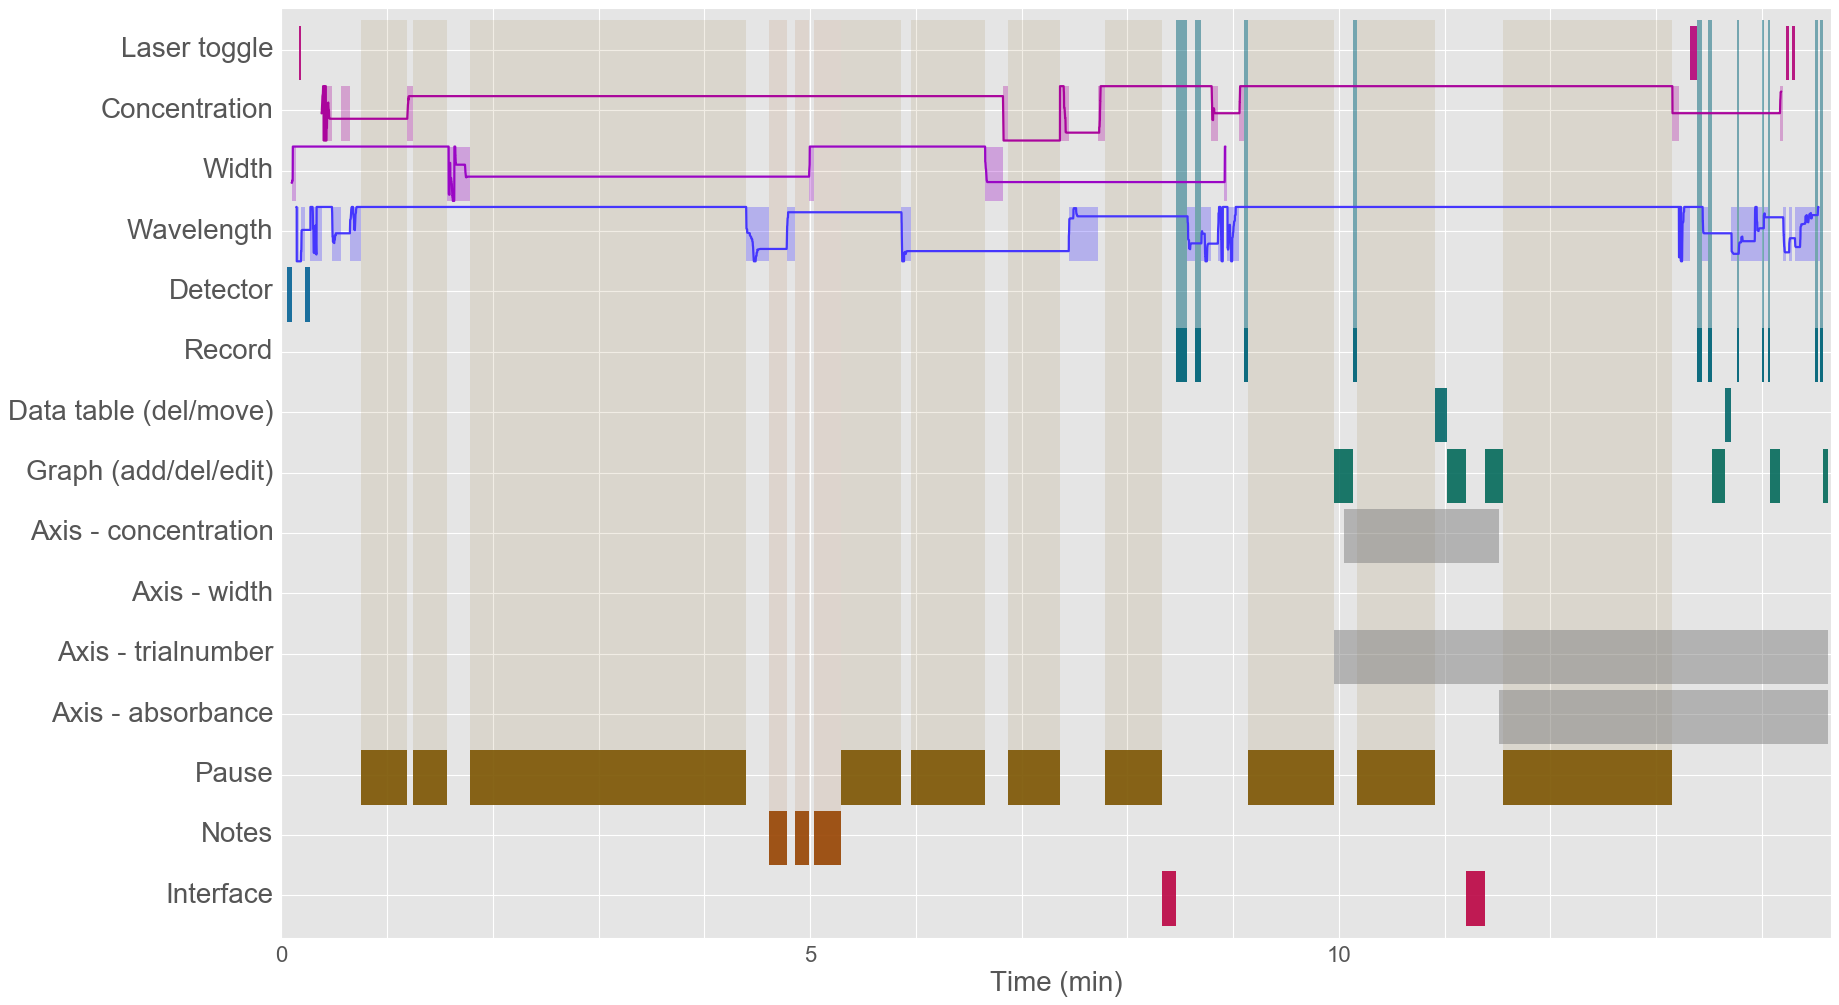

In [14]:
plot(df4,to_plot,family_name_to_code,function_to_use)